Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:260: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(


Episode 0, Reward: -884.1520162709057

Episode 1, Reward: -1613.9150075912476

Episode 2, Reward: -1163.7238988876343

Episode 3, Reward: -1182.2277125464752

Episode 4, Reward: -1161.939614981413

Episode 5, Reward: -1442.6381783485413

Episode 6, Reward: -1565.5961785316467

Episode 7, Reward: -1040.512121617794

Episode 8, Reward: -1685.9095063209534

Episode 9, Reward: -1300.8737394809723

Episode 10, Reward: -1676.1568546295166

Episode 11, Reward: -1317.5507209300995

Episode 12, Reward: -1612.1643137931824

Episode 13, Reward: -1560.9028334617615

Episode 14, Reward: -1680.223876953125

Episode 15, Reward: -1391.1597311012447

Episode 16, Reward: -1577.190868139267

Episode 17, Reward: -1784.911204814911

Episode 18, Reward: -1195.136821076274

Episode 19, Reward: -1698.8289279937744

Episode 20, Reward: -1766.1046977043152

Episode 21, Reward: -1591.6325974464417

Episode 22, Reward: -915.3798181256279

Episode 23, Reward: -1317.8720835149288

Episode 24, Reward: -1856.25763225

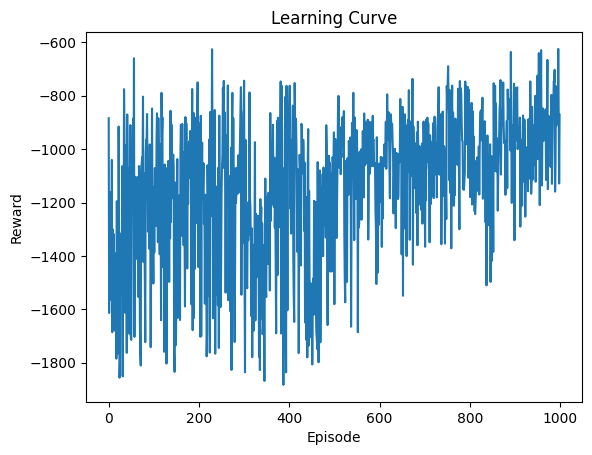

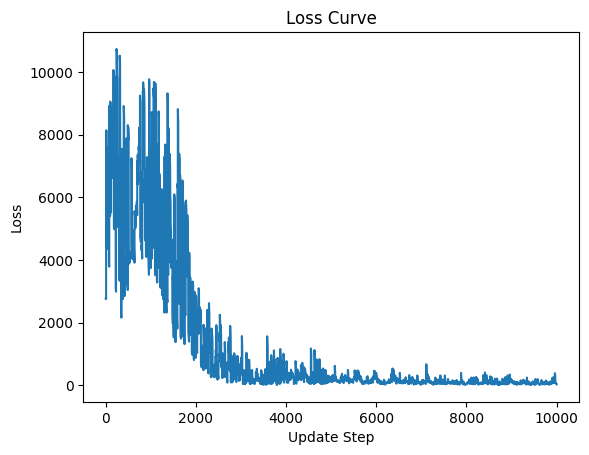

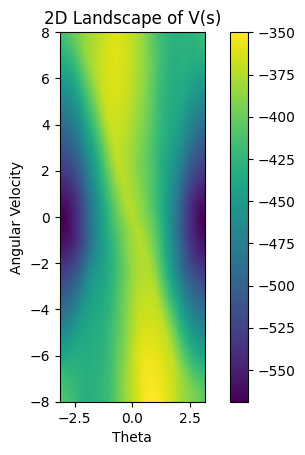

In [ ]:
# Install dependencies for Colab
!apt-get install -y xvfb ffmpeg
!pip install gym Box2D PyOpenGL PyOpenGL_accelerate pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# Import required libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Policy and Critic Networks
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.mu = nn.Linear(64, output_dim)
        self.log_std = nn.Parameter(torch.zeros(1, output_dim))

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mu = self.mu(x)
        std = torch.exp(self.log_std)
        return mu, std

class CriticNetwork(nn.Module):
    def __init__(self, input_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.value = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.value(x)
        return value

# Replay Buffer
class ReplayBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.advantages = []

    def store(self, state, action, reward, log_prob, value):
        self.states.append(np.array(state, dtype=np.float32).reshape(-1))
        self.actions.append(np.array(action, dtype=np.float32).reshape(-1))
        self.rewards.append(float(reward))
        self.log_probs.append(log_prob.item())
        self.values.append(value.item())

    def compute_advantages(self, gamma, lam, next_value):
        returns = []
        advantages = []
        gae = 0

        for i in reversed(range(len(self.rewards))):
            delta = self.rewards[i] + gamma * next_value - self.values[i]
            gae = delta + gamma * lam * gae
            advantages.insert(0, gae)
            next_value = self.values[i]
            returns.insert(0, gae + self.values[i])

        self.advantages = advantages
        self.returns = returns

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.advantages = []

# PPOAgent Class
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, lam=0.95, clip_ratio=0.2, epochs=10):
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.critic_net = CriticNetwork(state_dim).to(device)
        self.optimizer = optim.Adam(list(self.policy_net.parameters()) + list(self.critic_net.parameters()), lr=lr)
        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.epochs = epochs
        self.buffer = ReplayBuffer()

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(device)
        mu, std = self.policy_net(state)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()
        value = self.critic_net(state)
        return action.cpu().detach().numpy(), log_prob.detach(), value.detach()

    def store_transition(self, state, action, reward, log_prob, value):
        self.buffer.store(state, action, reward, log_prob, value)

    def update(self, next_state):
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        next_value = self.critic_net(next_state).detach()
        self.buffer.compute_advantages(self.gamma, self.lam, next_value)

        states = torch.tensor(np.array(self.buffer.states), dtype=torch.float32).to(device)
        actions = torch.tensor(np.array(self.buffer.actions), dtype=torch.float32).to(device)
        returns = torch.tensor(self.buffer.returns, dtype=torch.float32).to(device)
        advantages = torch.tensor(self.buffer.advantages, dtype=torch.float32).to(device)
        old_log_probs = torch.tensor(np.array(self.buffer.log_probs), dtype=torch.float32).to(device)

        loss_history = []
        for _ in range(self.epochs):
            mu, std = self.policy_net(states)
            dist = torch.distributions.Normal(mu, std)
            new_log_probs = dist.log_prob(actions).sum(dim=-1)
            ratio = torch.exp(new_log_probs - old_log_probs)

            clipped_ratio = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio)
            surrogate_loss = torch.min(ratio * advantages, clipped_ratio * advantages)
            policy_loss = -surrogate_loss.mean()

            values = self.critic_net(states).squeeze()
            value_loss = ((returns - values) ** 2).mean()

            loss = policy_loss + 0.5 * value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            loss_history.append(loss.item())

        self.buffer.clear()
        return loss_history

# Train the Agent and Save Output
def train():
    env = gym.make('Pendulum-v1', new_step_api=True)
    agent = PPOAgent(state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0])
    num_episodes = 1000
    max_timesteps = 200
    rewards_history = []
    loss_history_total = []

    with open('rewards_log.txt', 'w') as file:
        for episode in range(num_episodes):
            state = env.reset()
            state = np.array(state, dtype=np.float32).reshape(-1)
            episode_reward = 0

            for t in range(max_timesteps):
                action, log_prob, value = agent.select_action(state.reshape(1, -1))
                action = action.clip(env.action_space.low, env.action_space.high)

                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                reward = float(reward) if np.isscalar(reward) else reward.item()

                agent.store_transition(state, action, reward, log_prob, value)
                episode_reward += reward

                if done or t == max_timesteps - 1:
                    loss_history = agent.update(next_state.reshape(1, -1))
                    loss_history_total.extend(loss_history)
                    break

                state = np.array(next_state, dtype=np.float32).reshape(-1)

            rewards_history.append(episode_reward)
            log_entry = f"Episode {episode}, Reward: {episode_reward}\n"
            print(log_entry)
            file.write(log_entry)

    # Plotting learning curve
    plt.plot(rewards_history)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Learning Curve')
    plt.savefig('learning_curve.png')
    plt.show()

    # Plotting loss curve
    plt.plot(loss_history_total)
    plt.xlabel('Update Step')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.savefig('loss_curve.png')
    plt.show()

    # Visualizing the 2D landscape of V(s)
    theta_range = np.linspace(-np.pi, np.pi, 100)
    theta_dot_range = np.linspace(-8, 8, 100)
    theta, theta_dot = np.meshgrid(theta_range, theta_dot_range)

    V = np.zeros_like(theta)

    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            state = np.array([theta[i, j], theta_dot[i, j]], dtype=np.float32).reshape(1, -1)
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            V[i, j] = agent.critic_net(state_tensor).item()

    plt.imshow(V, extent=[-np.pi, np.pi, -8, 8], origin='lower')
    plt.colorbar()
    plt.xlabel('Theta')
    plt.ylabel('Angular Velocity')
    plt.title('2D Landscape of V(s)')
    plt.savefig('value_function_landscape.png')
    plt.show()

train()
